In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# sys.path.append('/home/flynn/miniforge3/envs/suite2p/lib/python3.10/site-packages')

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tifffile
import dask

import scanreader
import zarr

In [12]:
import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (18, 13),
    'ytick.major.left': True,
})
jet = mpl.cm.get_cmap('jet')
jet.set_bad(color='k')

/tmp/ipykernel_1386727/1385736914.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = mpl.cm.get_cmap('jet')


In [13]:
data_path = Path().home() / 'caiman_data' / 'raw' / 'high_res_full.tif'

In [14]:
reader = tifffile.imread(str(data_path), aszarr=True)
array = zarr.open(reader)
array.info

Type,zarr.core.Array
Data type,int16
Shape,"(1730, 30, 2478, 145)"
Chunk shape,"(1, 1, 2478, 145)"
Order,C
Read-only,False
Compressor,None
Store type,zarr.storage.KVStore
No. bytes,37296378000 (34.7G)
No. bytes stored,252
Storage ratio,148001500.0


In [16]:
scan = scanreader.read_scan([data_path])
scan.yslices

DEBUG:scanreader.scans:Initializing scan with files: ['/home/flynn/caiman_data/raw/high_res_full.tif']


[slice(0, 600, None),
 slice(624, 1224, None),
 slice(1248, 1848, None),
 slice(1872, 2472, None)]

In [17]:
array.shape

(1730, 30, 2478, 145)

In [18]:
image = array[:, 0, ...]
image.shape

(1730, 2478, 145)

In [19]:
for i in range(0, len(scan.yslices)):
    im = image[0, scan.yslices[i], ...]
    print(im.shape)

(600, 145)
(600, 145)
(600, 145)
(600, 145)


In [20]:
array = zarr.open(reader)
array.nbytes

37296378000

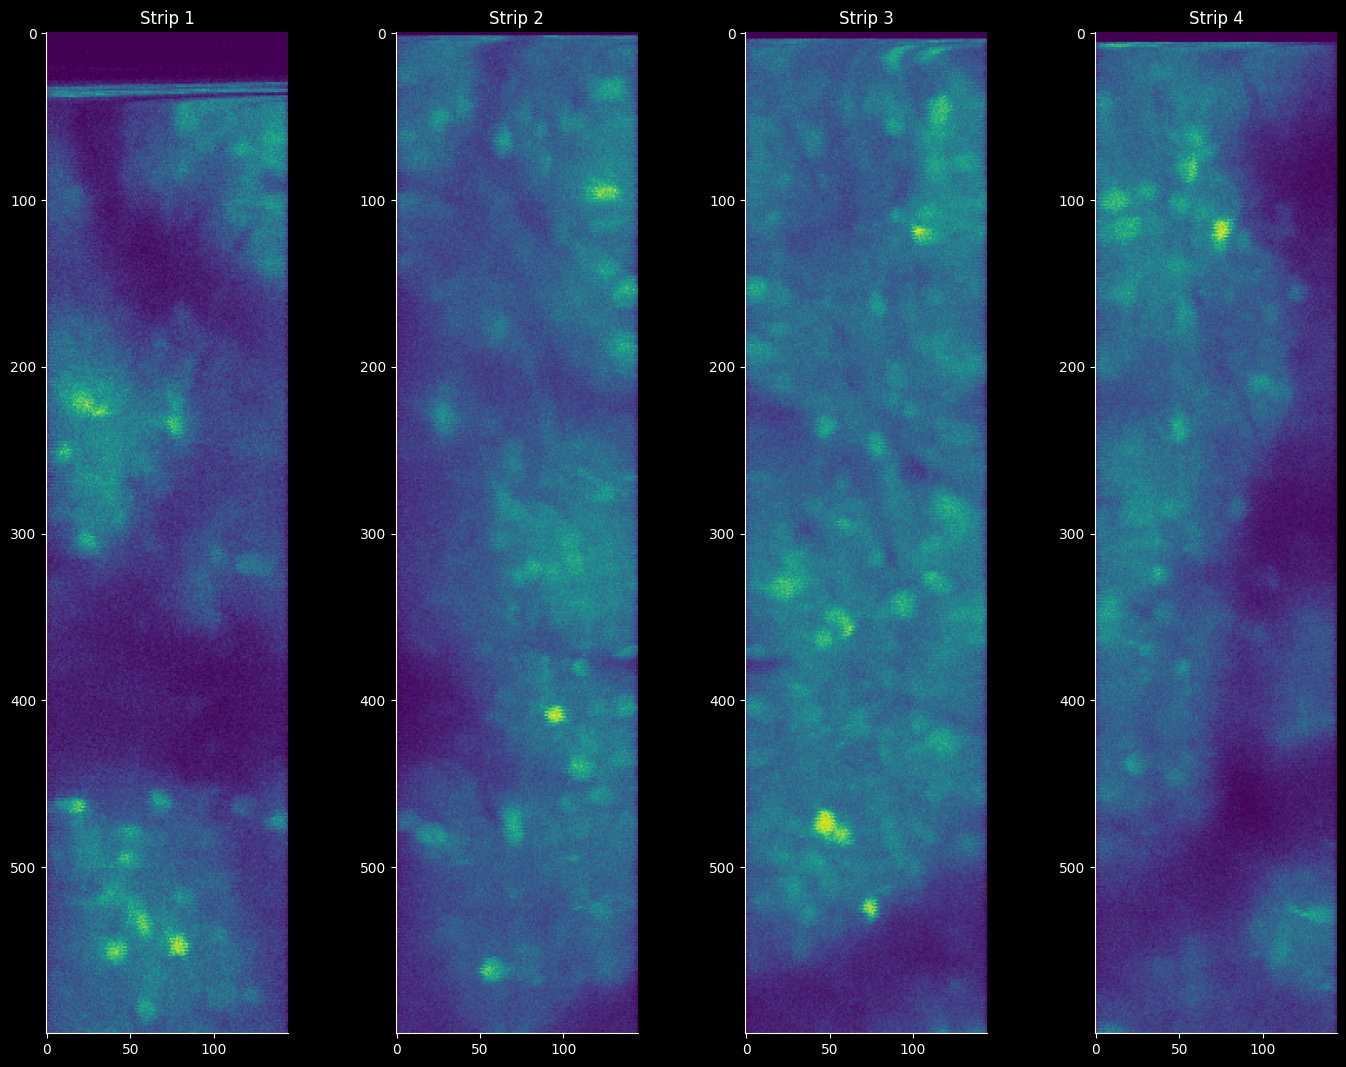

In [21]:
plt.subplot(1, 4, 1)
plt.imshow(image[0, scan.yslices[0], ...])
plt.title("Strip 1");

plt.subplot(1, 4, 2)
plt.imshow(image[0, scan.yslices[1], ...])
plt.title("Strip 2");

plt.subplot(1, 4, 3)
plt.imshow(image[0, scan.yslices[2], ...])
plt.title("Strip 3");

plt.subplot(1, 4, 4)
plt.imshow(image[0, scan.yslices[3], ...])
plt.title("Strip 4");

In [22]:
def return_scan_offset(image_in, nvals: int=8):
    from scipy import signal
    image_in = image_in.squeeze()

    if len(image_in.shape) == 3:
        image_in = np.mean(image_in, axis=0)
    elif (image_in.shape)==2:
        image_in = image_in
    else:
        raise ValueError(f'Input must be 2 or 3 dimensional. Input has shape: {image_in.shape}')

    n = nvals

    in_pre = image_in[::2, :]
    in_post = image_in[1::2, :]

    min_len = min(in_pre.shape[0], in_post.shape[0])
    in_pre = in_pre[:min_len, :]
    in_post = in_post[:min_len, :]

    buffers = np.zeros((in_pre.shape[0], n))

    in_pre = np.hstack((buffers, in_pre, buffers))
    in_post = np.hstack((buffers, in_post, buffers))

    in_pre = in_pre.T.ravel(order='F')
    in_post = in_post.T.ravel(order='F')

    # Zero-center and clip negative values to zero
    # Iv1 = Iv1 - np.mean(Iv1)
    in_pre[in_pre < 0] = 0

    in_post = in_post - np.mean(in_post)
    in_post[in_post < 0] = 0

    in_pre = in_pre[:, np.newaxis]
    in_post = in_post[:, np.newaxis]

    r_full = signal.correlate(in_pre[:, 0], in_post[:, 0], mode='full', method='auto')
    unbiased_scale = len(in_pre) - np.abs(np.arange(-len(in_pre) + 1, len(in_pre)))
    r = r_full / unbiased_scale

    mid_point = len(r) // 2
    lower_bound = mid_point - n
    upper_bound = mid_point + n + 1
    r = r[lower_bound:upper_bound]
    lags = np.arange(-n, n + 1)

    # Step 3: Find the correction value
    correction_index = np.argmax(r)
    return lags[correction_index]

offset = return_scan_offset(image[:, scan.yslices[0], ...])

In [80]:
def fix_scan_phase(data_in, offset,):

    dims = data_in.shape
    ndim = len(dims)

    if ndim != 3:
        raise ValueError('Must be 3D')
    st, sy, sx = data_in.shape
    if offset != 0:
        # Create output array with appropriate shape adjustment
        data_out = np.zeros((st, sy, sx + abs(offset)))
    else:
        print('Phase = 0, no correction applied.')
        return data_in
    if offset > 0:
        data_out[:, 0::2, :sx] = data_in[:, 0::2, :]
        data_out[:, 1::2, offset:offset + sx] = data_in[:, 1::2, :]
        data_out = data_out[:, :, :sx + offset]
    elif offset < 0:
        offset = abs(offset)
        data_out[:, 0::2, offset:offset + sx] = data_in[:, 0::2, :]
        data_out[:, 1::2, :sx] = data_in[:, 1::2, :]
        data_out = data_out[:, :, offset:]
    return data_out

new0 = fix_scan_phase(image[:, scan.yslices[0], ...], offset)
new1 = fix_scan_phase(image[:, scan.yslices[1], ...], offset)
new2 = fix_scan_phase(image[:, scan.yslices[2], ...], offset)
new3 = fix_scan_phase(image[:, scan.yslices[3], ...], offset)

mean_img_0 = np.mean(new, axis=0)

In [90]:
for i in range(4):
    # fix the scan phase for each slice
    new_img = fix_scan_phase(image[:, scan.yslices[i], ...], offset)
    # store = zarr.save_array(f'/home/flynn/caiman_data/strips/strip_{i}.tiff', new_img)
    tifffile.imwrite(f'/home/flynn/caiman_data/strips/strip_{i}.tiff', new_img)

In [32]:
import suite2p

ops = suite2p.default_ops()

ops['batch_size'] = 1000 
ops['fs'] = 10 
ops['tau'] = 0.1
ops['preclassify'] = 0.0 
ops['aspect'] = 1.0 
ops['do_bidiphase'] = True 
ops['bidiphase'] = -1 
ops['do_registration'] = 1 
ops['two_step_registration'] = 0 
ops['nimg_init'] = 500 
ops['maxregshift'] = 0.5 
ops['align_by_chan'] = 1 
ops['reg_tif'] = False 
ops['reg_tif_chan2'] = False 
ops['subpixel'] = False 
ops['th_badframes'] = 1.0 
ops['smooth_sigma'] = 1.15 
ops['th_badframes'] = 1.0
ops['norm_frames'] = True
ops['force_refImg'] = False
ops['pad_fft'] = False
ops['nonrigid'] = True
ops['block_size'] = [128, 128]
ops['snr_thresh'] = 0.8
ops['maxregshiftNR'] = 5.0
ops['1Preg'] = False
ops['spatial_hp_reg'] = 42.0
ops['pre_smooth'] = 0.0
# ops['spatial_taper'] = 40.0
ops['roidetect'] = True
ops['spikedetect'] = True
ops['sparse_mode'] = True
# ops['spatial_scale'] = 0
ops['connected'] = True
# ops['nbinned'] = 5000
# ops['max_iterations'] = 20
# ops['threshold_scaling'] = 1.0
# ops['max_overlap'] = 0.75
# ops['high_pass'] = 100.0
# ops['spatial_hp_detect'] = 25.0
# ops['denoise'] = 0.0
# ops['anatomical_only'] = 3
# ops['cellprob_threshold'] = -5.0
# ops['flow_threshold'] = -5.0
# ops['spatial_hp_cp'] = 0.0
# ops['pretrained_model'] = 'cyto'
# ops['soma_crop'] = 1.0
ops['neuropil_extract'] = True
# ops['inner_neuropil_radius'] = 2
# ops['min_neuropil_pixels'] = 350
# ops['lam_percentile'] = 50.0
# ops['allow_overlap'] = False
# ops['use_builtin_classifier'] = False
# ops['baseline'] = 'maxmin'
# ops['win_baseline'] = 60.0
# ops['sig_baseline'] = 10.0
# ops['prctile_baseline'] = 8.0
# ops['neucoeff'] = 0.7
ops["keep_movie_raw"]=1

print(ops)

{'suite2p_version': '0.14.4', 'look_one_level_down': False, 'fast_disk': [], 'delete_bin': False, 'mesoscan': False, 'bruker': False, 'bruker_bidirectional': False, 'h5py': [], 'h5py_key': 'data', 'nwb_file': '', 'nwb_driver': '', 'nwb_series': '', 'save_path0': '', 'save_folder': [], 'subfolders': [], 'move_bin': False, 'nplanes': 1, 'nchannels': 1, 'functional_chan': 1, 'tau': 0.1, 'fs': 10, 'force_sktiff': False, 'frames_include': -1, 'multiplane_parallel': False, 'ignore_flyback': [], 'preclassify': 0.0, 'save_mat': False, 'save_NWB': False, 'combined': True, 'aspect': 1.0, 'do_bidiphase': True, 'bidiphase': -1, 'bidi_corrected': False, 'do_registration': 1, 'two_step_registration': 0, 'keep_movie_raw': 1, 'nimg_init': 500, 'batch_size': 1000, 'maxregshift': 0.5, 'align_by_chan': 1, 'reg_tif': False, 'reg_tif_chan2': False, 'subpixel': False, 'smooth_sigma_time': 0, 'smooth_sigma': 1.15, 'th_badframes': 1.0, 'norm_frames': True, 'force_refImg': False, 'pad_fft': False, 'nonrigid': 

In [33]:
data_path = Path(f"/home/flynn/caiman_data/strips/")
for i in range(4):
    print(f'Processing strip: {i+1}')
    savename = Path(f'strip_{i}')
    savepath =  str(data_path / 'results' / savename)
    db = {
        'data_path': [str(data_path)],
        'save_path0': savepath,
        'tiff_list': [savename.with_suffix('.tiff')],
    }
    Path(savepath).mkdir(exist_ok=True)
    output_ops = suite2p.run_s2p(ops=ops, db=db)

Processing strip: 1
{'data_path': ['/home/flynn/caiman_data/strips'], 'save_path0': '/home/flynn/caiman_data/strips/results/strip_0', 'tiff_list': [PosixPath('strip_0.tiff')]}
FOUND BINARIES AND OPS IN ['/home/flynn/caiman_data/strips/results/strip_0/suite2p/plane0/ops.npy']
removing previous detection and extraction files, if present


>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not running registration, plane already registered
binary path: /home/flynn/caiman_data/strips/results/strip_0/suite2p/plane0/data.bin
NOTE: applying default /home/flynn/.suite2p/classifiers/classifier_user.npy
----------- ROI DETECTION
Binning movie in chunks of length 01
Binned movie of size [1730,592,142] created in 0.88 sec.
